# Performing Stock Market Prediction using LSTM

## Pre-Processing Data

**Importing necessary libraries and extracting data**

In [1]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('/content/x_train.csv')    # Change path according to your machine
df.tail()

,Open,High,Low,Volume,Adj Close
3454,67004.000000,67347.0,65897.000000,5788.0,65936.664063
3455,66200.000000,67503.0,65105.199219,9920.0,67135.382813
3456,67398.898438,67699.0,66526.000000,8775.0,66503.914063
3457,67279.000000,67475.0,66980.000000,4257.0,66853.562500
3458,67550.000000,67550.0,66812.398438,5943.0,66801.398438


**Removing nan values**

In [4]:
df1 = df.reset_index()['Adj Close']
df1 = df1[~np.isnan(df1)]
df1

0        2398.945068
1        2406.021484
2        2431.730957
3        2370.639404
4        2357.806885
            ...     
3454    65936.664063
3455    67135.382813
3456    66503.914063
3457    66853.562500
3458    66801.398438
Name: Adj Close, Length: 3445, dtype: float64

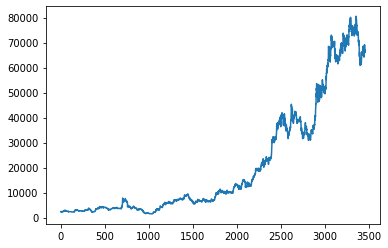

In [5]:
plt.plot(df1)

**Scaling data to (0,1) range**

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.01149373],
       [0.01158326],
       [0.01190855],
       ...,
       [0.82258392],
       [0.82700786],
       [0.82634785]])

**Dividing the data into training and testing set**

In [7]:
train_size=int(len(df1)*0.65)
test_size=len(df1)-train_size
training_data,testing_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

training_data.shape
testing_data.shape

(1206, 1)

**Creating function for adding features to dataset to be feeded to our model**

In [8]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train,y_train = create_dataset(training_data,time_step)
X_test,y_test = create_dataset(testing_data,time_step)
X_train.shape

print(np.any(np.isnan(X_train)))
X_train.shape

False


(2138, 100)

In [10]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## Model Training

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

In [13]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
34/34 [==============================] - 11s 52ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 2/100
34/34 [==============================] - 1s 17ms/step - loss: 6.1146e-05 - val_loss: 0.0018
Epoch 3/100
34/34 [==============================] - 1s 17ms/step - loss: 4.5886e-05 - val_loss: 0.0014
Epoch 4/100
34/34 [==============================] - 1s 17ms/step - loss: 4.0650e-05 - val_loss: 0.0013
Epoch 5/100
34/34 [==============================] - 1s 17ms/step - loss: 4.2080e-05 - val_loss: 0.0012
Epoch 6/100
34/34 [==============================] - 1s 17ms/step - loss: 3.8387e-05 - val_loss: 0.0011
Epoch 7/100
34/34 [==============================] - 1s 17ms/step - loss: 3.8857e-05 - val_loss: 7.7261e-04
Epoch 8/100
34/34 [==============================] - 1s 17ms/step - loss: 3.2169e-05 - val_loss: 8.0919e-04
Epoch 9/100
34/34 [==============================] - 1s 17ms/step - loss: 3.3789e-05 - val_loss: 7.2837e-04
Epoch 10/100
34/34 [==============================] - 1

## Predicting output and analyzing results

In [15]:
import tensorflow as tf
import math
from sklearn import metrics

In [16]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

test_predict

array([[0.27687147],
       [0.27954832],
       [0.2787129 ],
       ...,
       [0.7932658 ],
       [0.80791473],
       [0.8089099 ]], dtype=float32)

In [17]:
y_train

array([0.01140524, 0.01103155, 0.0111959 , ..., 0.21836004, 0.21968126,
       0.22474284])

In [18]:
math.sqrt(metrics.mean_squared_error(y_true=y_train,y_pred=train_predict))

0.0025160116250648274

In [19]:
math.sqrt(metrics.mean_squared_error(y_true=y_test,y_pred=test_predict))

0.016411016924835365

In [20]:
metrics.mean_absolute_error(y_test,test_predict)

0.011953750982803641

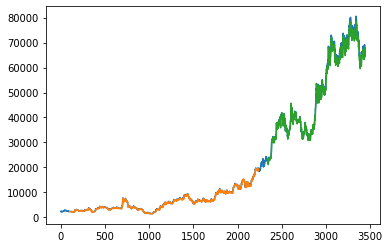

In [21]:
### Plotting 

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
x_input=testing_data[340:].reshape(1,-1)
x_input.shape

(1, 866)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

## Prediction on unseen data

In [25]:
lst_output=[]
n_steps=865
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}\n".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}\n".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

lst_output

0 day input [0.41078101 0.41737674 0.418023   0.41868706 0.41839591 0.4217169
 0.41953182 0.42252142 0.42294311 0.42940208 0.42653534 0.42855233
 0.43425704 0.43571782 0.44049731 0.43492955 0.43748368 0.45927016
 0.46476017 0.47046464 0.47423    0.47697619 0.47569339 0.4937233
 0.51525485 0.55473119 0.55077372 0.54303155 0.54500985 0.53984331
 0.51511715 0.50228887 0.50649756 0.5154522  0.51582639 0.53516524
 0.53410712 0.52648051 0.52575754 0.46802176 0.48175247 0.48409957
 0.49461951 0.49587102 0.4881465  0.47926334 0.48652974 0.48647212
 0.46663092 0.45818466 0.4747962  0.47728153 0.49093045 0.48995398
 0.49346101 0.48623602 0.4816344  0.48531347 0.50103246 0.50133118
 0.49496463 0.49906677 0.4988244  0.50298174 0.50752301 0.50368213
 0.51934582 0.51522613 0.51570589 0.50702092 0.5004676  0.49708863
 0.49804123 0.4989739  0.50643104 0.50705991 0.5072583  0.51049799
 0.51116309 0.51624931 0.51130503 0.50303571 0.49888974 0.49150659
 0.4801031  0.47517518 0.47985459 0.47092126 0.46510

[[0.8127853870391846],
 [0.7987116575241089],
 [0.7811283469200134],
 [0.762079656124115],
 [0.7428153157234192],
 [0.7242060303688049],
 [0.7067058682441711],
 [0.6904171109199524],
 [0.6752026081085205],
 [0.6608089208602905],
 [0.646973192691803],
 [0.6334946155548096],
 [0.6202694773674011],
 [0.6072915196418762],
 [0.5946311354637146],
 [0.5824014544487],
 [0.570724606513977],
 [0.5597044229507446],
 [0.5494097471237183],
 [0.5398678779602051],
 [0.5310685634613037],
 [0.522972583770752],
 [0.5155231356620789],
 [0.5086571574211121],
 [0.502313494682312],
 [0.49643847346305847],
 [0.4909875690937042],
 [0.4859254062175751],
 [0.4812230169773102],
 [0.47685590386390686]]

In [26]:
day=np.arange(1,101)
day_pred=np.arange(101,131)

In [27]:
len(df1)

3445

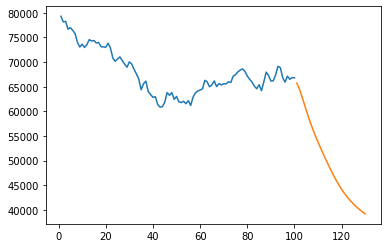

In [31]:
plt.plot(day,scaler.inverse_transform(df1[3345:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

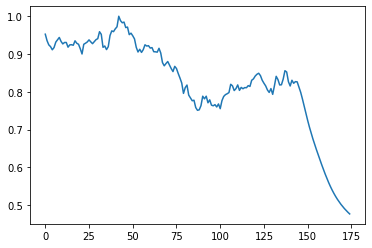

In [32]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[3300:])

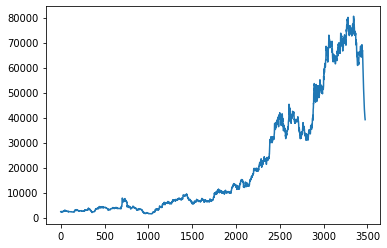

In [33]:
df3=scaler.inverse_transform(np.array(df3).reshape(-1,1))
plt.plot(df3)